In [36]:
import pandas as pd
import numpy as np

df = pd.read_csv("weight_sweep.csv")

# Columns

turns_col = "avg_turns_win_vs_intuitive_gamer"
win_col   = "win_rate_vs_intuitive_gamer"

# ---- Discounted Turns Metric ----
beta = 1.5        # risk-aversion (1.0 = expected turns per win)
eps = 1e-6        # numerical safety

df["metric"] = (
    df[turns_col] /
    (df[win_col] + eps) ** beta
)

# ---- Voxelization ----
BIN_SIZE = 0.6
WEIGHT_MIN = 0.0
WEIGHT_MAX = 2.5

bins = np.arange(WEIGHT_MIN, WEIGHT_MAX + BIN_SIZE, BIN_SIZE)

for w in ["w_connect", "w_block", "w_center"]:
    df[f"{w}_bin"] = pd.cut(
        df[w],
        bins=bins,
        labels=False,
        include_lowest=True
    )

# ---- Aggregate within voxels ----
voxel_df = (
    df
    .groupby(["w_connect_bin", "w_block_bin", "w_center_bin"], dropna=True)
    .agg(
        metric_mean=("metric", "mean"),
        metric_std=("metric", "std"),
        count=("metric", "count"),
        win_rate_mean=(win_col, "mean"),
        turns_mean=(turns_col, "mean"),
    )
    .reset_index()
)

# ---- Bin center helper ----
def bin_center(bin_idx):
    return WEIGHT_MIN + (bin_idx + 0.5) * BIN_SIZE

# ---- Best voxel ----
best_voxel = voxel_df.loc[voxel_df["metric_mean"].idxmin()]

best_weights = {
    "w_connect": bin_center(best_voxel["w_connect_bin"]),
    "w_block": bin_center(best_voxel["w_block_bin"]),
    "w_center": bin_center(best_voxel["w_center_bin"]),
}

print("Best voxel center:", best_weights)
print("Metric (discounted turns):", best_voxel["metric_mean"])
print("Win rate:", best_voxel["win_rate_mean"])
print("Avg turns:", best_voxel["turns_mean"])
print("Voxel count:", best_voxel["count"])


Best voxel center: {'w_connect': np.float64(0.8999999999999999), 'w_block': np.float64(0.3), 'w_center': np.float64(0.3)}
Metric (discounted turns): 7.966654429179928
Win rate: 0.7945833333333333
Avg turns: 5.555625
Voxel count: 48.0


In [27]:
import matplotlib.pyplot as plt

def plot_heatmap_for_w3(voxel_df, w3_bin_idx):
    print(np.unique(voxel_df["w_center_bin"]))
    slice_df = voxel_df[voxel_df["w_center_bin"] == w3_bin_idx]

    pivot = slice_df.pivot(
        index="w_block_bin",
        columns="w_connect_bin",
        values="metric_mean"
    )

    plt.figure(figsize=(6, 5))
    plt.imshow(
        pivot,
        origin="lower",
        aspect="auto",
    )
    plt.colorbar(label="Scalarized Metric (lower = better)")

    plt.xlabel("w_connect")
    plt.ylabel("w_block")

    plt.xticks(
        ticks=np.arange(len(pivot.columns)),
        labels=[f"{bin_center(b):.2f}" for b in pivot.columns],
        rotation=45,
    )
    plt.yticks(
        ticks=np.arange(len(pivot.index)),
        labels=[f"{bin_center(b):.2f}" for b in pivot.index],
    )

    plt.title(f"Metric Heatmap (w3 ≈ {bin_center(w3_bin_idx):.2f})")
    plt.tight_layout()
    plt.show()


[0 1 2 3]


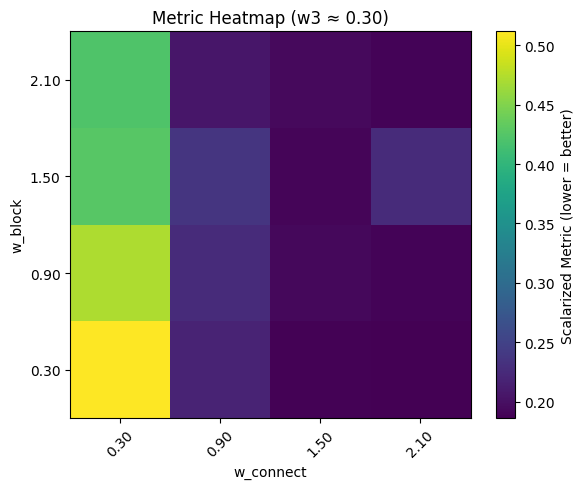

[0 1 2 3]


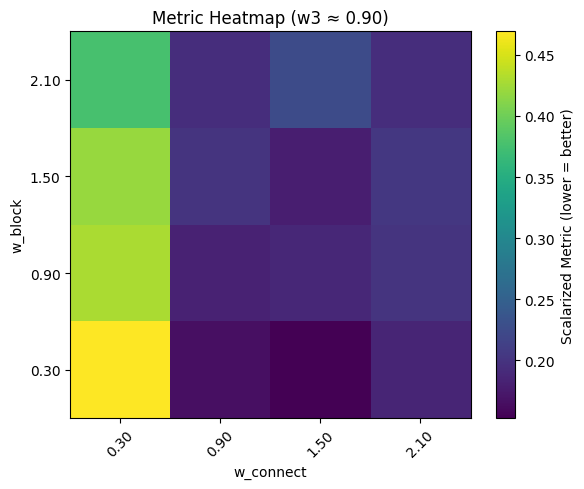

[0 1 2 3]


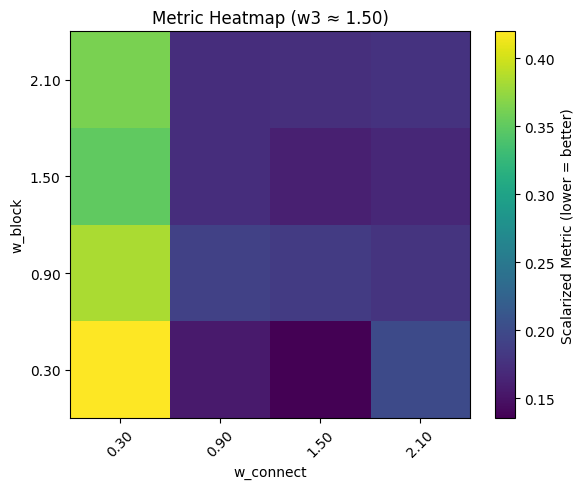

[0 1 2 3]


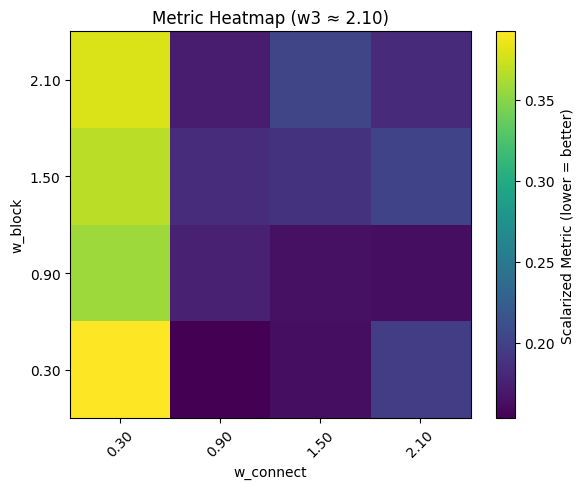

In [25]:
w3_bins_to_plot = [0, 1, 2, 3]  # choose slices you care about

for b in w3_bins_to_plot:
    plot_heatmap_for_w3(voxel_df, b)
